In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-04-08 15:57:39.383737: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 15:57:45.044637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 15:57:45.050867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 15:57:45.994059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 15:57:47.281841: I tensorflow/core/platform/cpu_feature_guar

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-08 15:58:22.924295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 15:58:23.078570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 15:58:23.078607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import keras
print(keras.__version__)

3.0.0


In [3]:
import tensorflow_datasets as tfds
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:


# (training_set, test_set, validation_set), dataset_info = tfds.load('kitti',
#                                                          split=['train[:80%]', 'train[80:90%]', 'train[90%:]'],
#                                                         #  download=True,
#                                                          with_info=True,
#                                                          )
# print(f"Number of training samples: {training_set.cardinality()}")
# print(f"Number of validation samples: {validation_set.cardinality()}")
# print(f"Number of test samples: {test_set.cardinality()}")
# (test_set, validation_set), dataset_info = tfds.load('kitti',
#             split=['test', 'validation'],
#         #  download=True,
#         with_info=True,
#             )

In [5]:
def cut_image(image, box):
        h,w,ch = image.shape
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = h-int(ymin*h), int(xmin*w), h-int(ymax*h), int(xmax*w)                
        object = image[ymax:ymin, xmin:xmax, :]
        
        if object.shape[1]==0 or object.shape[0]==0:                
            print("error with image shape")
        return object

def transform_dataset(ds, ds_path, ds_name, ds_type, info):

    # create ds directory if not exists
    save_path = os.path.join(ds_path, ds_name, ds_type)
    os.makedirs(save_path, exist_ok=True)
    # create classes folders if not exist
    names = np.asarray(info.features["objects"]["type"].names)
    for name in names:
        os.makedirs(os.path.join(save_path, name), exist_ok=True)
    
    for el in ds:
        image = el["image"].numpy()
        image_name = bytes.decode(el["image/file_name"].numpy())
        boxes = el["objects"]["bbox"]
        classes = el["objects"]["type"]
        for i, (box, label) in enumerate(zip(boxes, classes)):
            file_name = os.path.join(save_path, names[label], str(i)+image_name)
            cv2.imwrite(file_name, cut_image(image, box))

In [6]:
# uncomment to transform datasets
path = os.path.join(os.getcwd(), "dataset")   
# transform_dataset(training_set.skip(0).take(1000), path, 'kitti', 'train', dataset_info)
# transform_dataset(test_set.skip(0).take(1000), path, 'kitti', 'test', dataset_info)

In [7]:
IMAGE_RES = 224

train_ds, valid_ds = keras.utils.image_dataset_from_directory(
    "dataset/kitti/train/",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(IMAGE_RES, IMAGE_RES),
    validation_split=0.2,
    seed=121,
    subset="both"
)

Found 14136 files belonging to 8 classes.
Using 11309 files for training.
Using 2827 files for validation.


2024-04-08 15:58:55.207150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 15:58:55.207413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 15:58:55.207441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 15:58:55.379788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 15:58:55.379868: I external/local_xla/xla/stream_executor

In [8]:
test_ds = keras.utils.image_dataset_from_directory(
    "dataset/kitti/test/",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(IMAGE_RES, IMAGE_RES)
)

Found 3958 files belonging to 8 classes.


In [9]:
class_names = np.asarray(['Car', 'Cyclist', 'Misc', 'Pedestrian', 'Person_sitting', 'Tram', 'Truck', 'Van'])
NUM_CLASSES = len(class_names)

<BarContainer object of 8 artists>

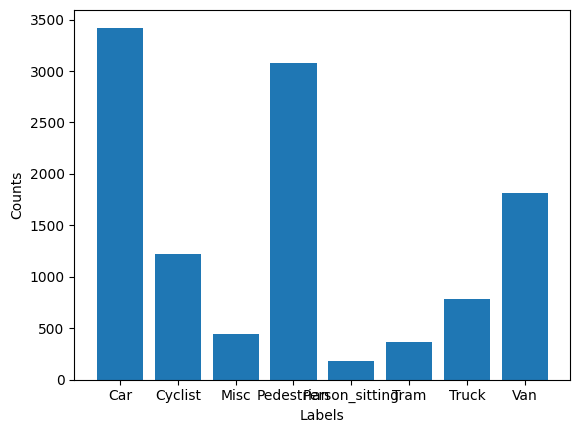

In [10]:
labels = list(train_ds.unbatch().map(lambda x,y: y).as_numpy_iterator())
# print(labels)
classes, counts = np.unique(labels, return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.bar(class_names[classes], counts) 

In [11]:
def plot_batch(ds,num):

    plt.figure(figsize=(10, 10))
    image_batch, label_batch = next(iter(ds.take(1)))
    image_batch = image_batch.numpy().astype(int)
    label_batch = label_batch.numpy()
        
    for i in range(num):
        ax = plt.subplot(int(np.sqrt(num)), int(np.sqrt(num)), i + 1)
        plt.imshow(image_batch[i])
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

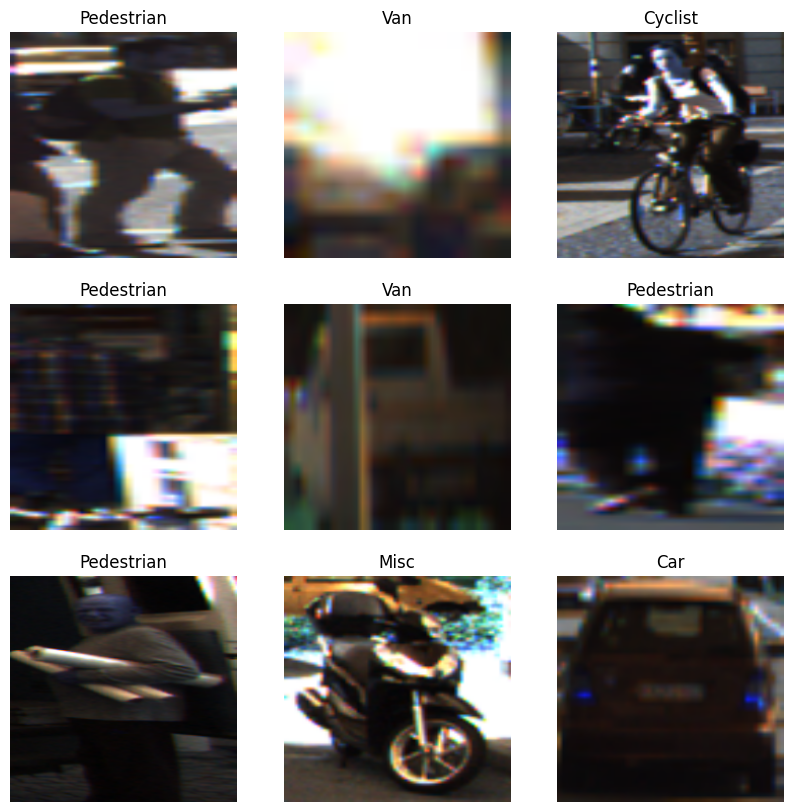

In [12]:
plot_batch(train_ds,9)

In [13]:
augmenter = keras.Sequential(
    [
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomTranslation(0.1,0.1),
        keras.layers.RandomZoom(0.1,0.1)
    ],
)

def preprocess_data(images, labels, augment=False):
    if augment:
        images = augmenter(images)
    return images, labels

In [14]:
train_batched_dataset = train_ds.map(lambda x, y: preprocess_data(x, y, augment=True)).prefetch(1)

In [15]:
valid_batched_dataset = valid_ds.prefetch(1)

2024-04-08 15:59:26.300325: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8124136879510372400
2024-04-08 15:59:26.300384: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 409903712359375466
2024-04-08 15:59:26.300390: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12643360480468206348
2024-04-08 15:59:26.300392: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 9713826882920427955
2024-04-08 15:59:26.300427: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3068935458635533245
2024-04-08 15:59:26.300446: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13369005216646068131
2024-04-08 15:59:26.300505: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send it

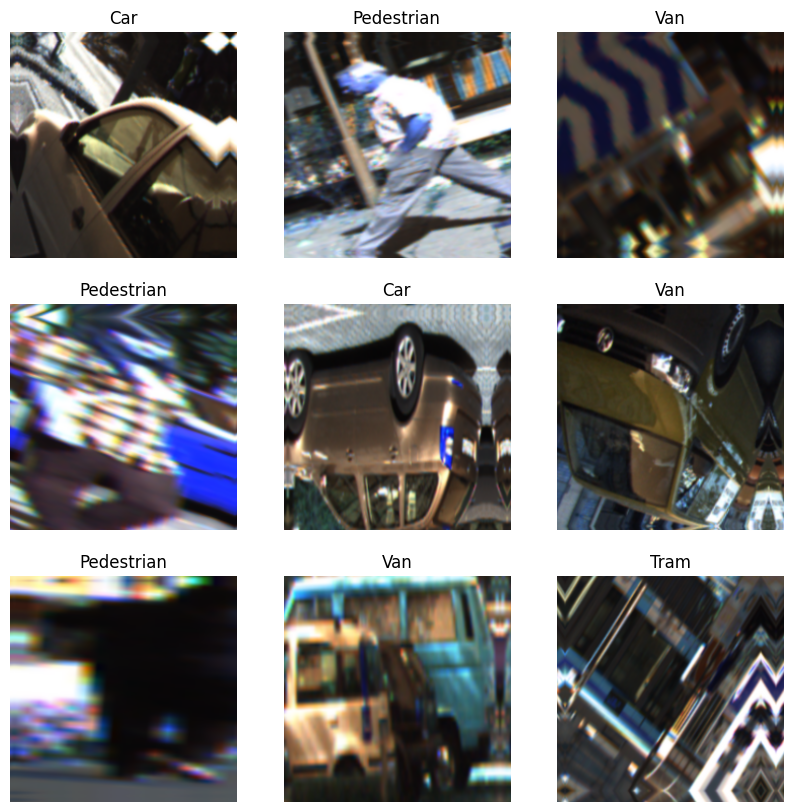

In [16]:
plot_batch(train_batched_dataset,9)
# plot_batch(train_ds,25)

In [17]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(IMAGE_RES, IMAGE_RES, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

# Pre-trained MobileNetV2 weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
# or map dataset with this function:
# def preprocess(images, labels):
#   return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape             ┃ Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 224, 224, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ rescaling (Rescaling)       │ (None, 224, 224, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)       │ 2,257,… │   N   │
│ (Functional)                │                          │         │       │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)             │       0 │   -   │
│ (GlobalAveragePooling2D)    │                          │         │       │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)             │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dense (Dense)               │ (None, 8)                │  10,248 │   Y   │
└─────────────────────────────┴──────────────────────────┴─────────┴───────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [38]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

my_callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

epochs = 100
print("Fitting the top layer of the model")
history = model.fit(train_batched_dataset, epochs=epochs, validation_data=valid_batched_dataset, callbacks=my_callbacks)

Fitting the top layer of the model
Epoch 1/100


2024-04-08 14:59:57.818148: I external/local_xla/xla/service/service.cc:168] XLA service 0x562b16ea4140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-08 14:59:57.818189: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-04-08 14:59:58.148677: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-08 14:59:59.105754: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  1/354 ━━━━━━━━━━━━━━━━━━━━ 2:42:41 28s/step - loss: 2.6073 - sparse_categorical_accuracy: 0.0938

I0000 00:00:1712581222.364202   58678 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


354/354 ━━━━━━━━━━━━━━━━━━━━ 186s 449ms/step - loss: 1.3062 - sparse_categorical_accuracy: 0.5536 - val_loss: 0.7283 - val_sparse_categorical_accuracy: 0.7527
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 128s 360ms/step - loss: 0.8199 - sparse_categorical_accuracy: 0.7117 - val_loss: 0.6170 - val_sparse_categorical_accuracy: 0.7955
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 130s 366ms/step - loss: 0.7497 - sparse_categorical_accuracy: 0.7380 - val_loss: 0.6329 - val_sparse_categorical_accuracy: 0.7856
Epoch 4/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 125s 352ms/step - loss: 0.7099 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.5839 - val_sparse_categorical_accuracy: 0.8051
Epoch 5/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 133s 374ms/step - loss: 0.6899 - sparse_categorical_accuracy: 0.7617 - val_loss: 0.5738 - val_sparse_categorical_accuracy: 0.8026
Epoch 6/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 137s 385ms/step - loss: 0.6952 - sparse_categorical_accuracy: 0.7504 - val_loss: 0.5735 - val_sparse_categorical_acc

In [39]:
import os
model.save(os.path.join(os.getcwd(), "models", "model_kitti_adam_14ep.keras"))

In [21]:
def plot_hist(hist):
    acc = hist.history['sparse_categorical_accuracy']
    val_acc = hist.history['val_sparse_categorical_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = hist.epoch

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
plot_hist(history)

In [24]:
test_batches = test_ds.prefetch(1)

In [42]:
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - loss: 1.4217 - sparse_categorical_accuracy: 0.5422
Test accuracy : 0.5409297347068787


In [18]:
model_sgd = model
model_sgd.compile(
    optimizer=keras.optimizers.SGD(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

my_callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

epochs = 20
print("Fitting the top layer of the model")
history_sgd = model_sgd.fit(train_batched_dataset, epochs=epochs, validation_data=valid_batched_dataset, callbacks=my_callbacks)

Fitting the top layer of the model
Epoch 1/20


2024-04-08 16:00:00.531365: I external/local_xla/xla/service/service.cc:168] XLA service 0x55dfba4d5af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-08 16:00:00.531408: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-04-08 16:00:00.961353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-08 16:00:01.857454: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  1/354 ━━━━━━━━━━━━━━━━━━━━ 2:25:09 25s/step - loss: 2.7068 - sparse_categorical_accuracy: 0.2188

I0000 00:00:1712584823.184981   93440 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


354/354 ━━━━━━━━━━━━━━━━━━━━ 184s 451ms/step - loss: 1.4236 - sparse_categorical_accuracy: 0.5233 - val_loss: 0.8107 - val_sparse_categorical_accuracy: 0.7393
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 140s 395ms/step - loss: 0.9212 - sparse_categorical_accuracy: 0.6802 - val_loss: 0.7361 - val_sparse_categorical_accuracy: 0.7556
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 138s 389ms/step - loss: 0.8319 - sparse_categorical_accuracy: 0.7175 - val_loss: 0.6883 - val_sparse_categorical_accuracy: 0.7690
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 135s 379ms/step - loss: 0.7938 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.6963 - val_sparse_categorical_accuracy: 0.7676
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 134s 377ms/step - loss: 0.7607 - sparse_categorical_accuracy: 0.7357 - val_loss: 0.6596 - val_sparse_categorical_accuracy: 0.7754
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 137s 385ms/step - loss: 0.7474 - sparse_categorical_accuracy: 0.7365 - val_loss: 0.6293 - val_sparse_categorical_accuracy

In [27]:
model_sgd.save(os.path.join(os.getcwd(), "models", "model_kitti_sgd_20epoch.keras"))

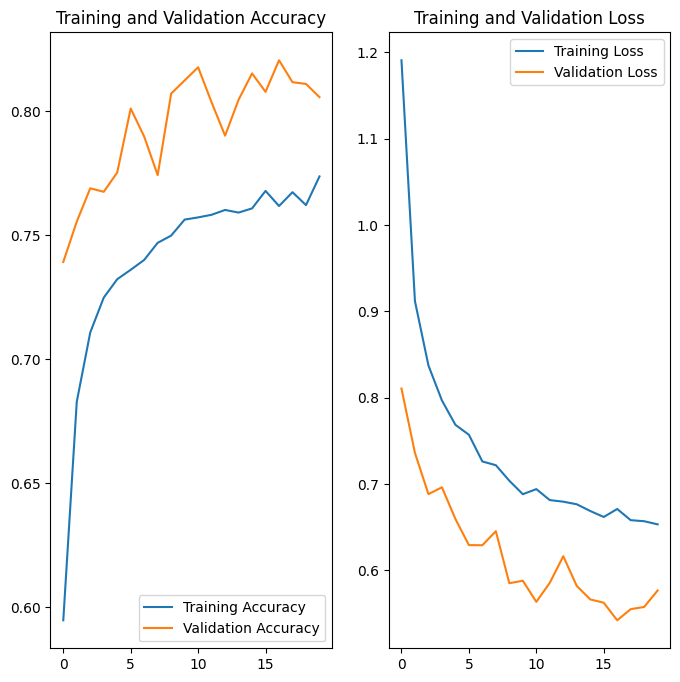

In [22]:
plot_hist(history_sgd)

In [25]:
loss, accuracy = model_sgd.evaluate(test_batches)
print('Test accuracy :', accuracy)

124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 1.3258 - sparse_categorical_accuracy: 0.5407
Test accuracy : 0.5366346836090088


In [28]:
ADD_EPOCHS = 20
TOTAL_EPOCHS =  epochs + ADD_EPOCHS
model_sgd2 = model_sgd
history_sgd2 = model_sgd2.fit(train_batched_dataset,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history_sgd.epoch[-1],
                         validation_data=valid_batched_dataset,
                         callbacks=my_callbacks)

Epoch 20/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 122s 342ms/step - loss: 0.6385 - sparse_categorical_accuracy: 0.7719 - val_loss: 0.5309 - val_sparse_categorical_accuracy: 0.8154
Epoch 21/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 124s 350ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.5632 - val_sparse_categorical_accuracy: 0.8097
Epoch 22/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 134s 379ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7751 - val_loss: 0.5678 - val_sparse_categorical_accuracy: 0.8136
Epoch 23/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 128s 362ms/step - loss: 0.6363 - sparse_categorical_accuracy: 0.7726 - val_loss: 0.5506 - val_sparse_categorical_accuracy: 0.8221
Epoch 24/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 130s 367ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.7774 - val_loss: 0.5369 - val_sparse_categorical_accuracy: 0.8111
Epoch 25/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 123s 346ms/step - loss: 0.6153 - sparse_categorical_accuracy: 0.7821 - val_loss: 0.5443 - val_sparse_cat

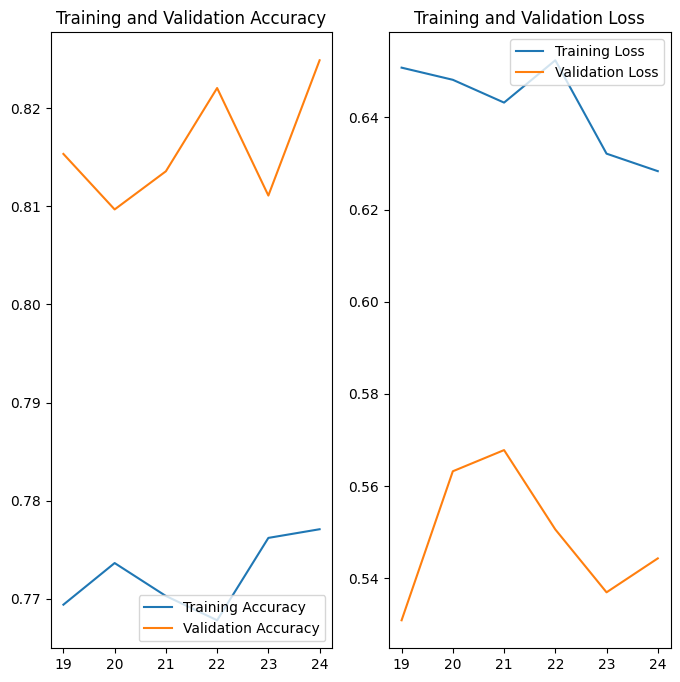

In [29]:
# history_sgd.history + history_sgd2.history
plot_hist(history_sgd2)

In [30]:
loss, accuracy = model_sgd2.evaluate(test_batches)
print('Test accuracy :', accuracy)

124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 1.2737 - sparse_categorical_accuracy: 0.5541
Test accuracy : 0.5515412092208862
